In [10]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
np.random.seed(12211)  

import zeropoints

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)

In [11]:
num_train = 200000
num_test = 20000
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7]
surveystring = surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS']

n_epochs = 2000 #20
D = 5 
K = 3
learning_rate = 1e-5
decay_rate= 1e-3 
batch_size = 1024 
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [12]:
def load_trained_models(save_mod):
    ## load rescaling routines for colors/magnitude
    preproc = Pipeline([('stdscaler', StandardScaler())])
    scalerfile = save_mod + '_scaling_X'
    preproc = pickle.load(open(scalerfile, 'rb'))
    
    ## load rescaling routine for redshift
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())])
    scalerfile = save_mod + '_scaling_y'
    preproc_y = pickle.load(open(scalerfile, 'rb'))

    ## Mixed density network
    non_lin_act = tf.nn.relu #tf.nn.tanh
    y_true = tf.keras.Input(shape=(1,))
    inputs = tf.keras.Input(shape=(D,))
    layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
    layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
    layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
    layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
    layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
    layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
    layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
    layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
    layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
    mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
    var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
    pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)
    model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')
    
    # load network weights
    model_train.load_weights(save_mod + '.h5')
    
    return preproc, preproc_y, model_train

In [13]:
def minmax_cutsOBSarr(X, y, l):
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    X_new = X[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    return X_new, y_new, l_new, mask_cond

In [14]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [15]:
def loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test)

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

In [16]:
## Loading color, redshift information from different surveys
X_test, y_test, X_err, label_test = loadTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_feb_2021/')

----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188479   -3.8901405  -2.1034117 -15.92296    12.114799 ]
ColMag-max:  [17.02884   7.925968  4.182415  2.264679 25.709858]
----------


In [17]:
## Removing galaxies outside the range of prediction scheme. 
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.001 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, y_test, label_test)
X_err = X_err[mask_cond]
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (2741, 5)
Size of output in test data: (2741,)


In [18]:
## Loading trained models and rescaling routines
preproc, preproc_y, model_train = load_trained_models(save_mod)

In [19]:
# Should cover at least the extent of the true redshifts.
zgrid = np.arange(-0.1,0.8,0.01)

# Selection. SDSS galaxies above z>0.01.
sel = (label_test==0)&(y_test>0.01)

# Value to reduce the likelihood ratio significance. 
# Adjust higher for larger samples.
extra_cov = (7.)**2
# Integration steps to marginalize photometric noise.
Nintegral = 10
# Clip galaxies with crazy low likelihoods. Roughly number of sigmas.
cutoff = 5
# Steps of the MCMC.
Nchain = 100

errors = X_err[sel].copy()
# Sometimes it's good to add more error. 
# Our models will not be accurate up to S/N~1000
# errors = np.sqrt(errors**2 + 0.02**2)

# Step size of the proposal distribution.
step_size = 0.005

xchain, P = zeropoints.run_zp_chain(
    preproc,
    preproc_y,
    model_train,
    y_test[sel], 
    X_test[sel].copy(), 
    errors, 
    Nintegral,
    Nchain,
    method = "exact", # Exact likelihood
    #method = "approximate", # Approximate likelihood.
    params_init = None,
    #params_init = pinit,
    cutoff = cutoff, 
    extra_cov = extra_cov,
    step_size = step_size,
    zgrid = zgrid
)

/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.2842209339141846
0 [0. 0. 0. 0.] 7419.79


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.162116289138794
0 [0. 0. 0. 0.] 7419.79


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.2097551822662354
1 [ 0.0068 -0.0012  0.0047  0.0005] 7569.87


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6657850742340088
2 [ 0.0083  0.0038 -0.0021 -0.0005] 7532.82


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6576778888702393
3 [ 0.0115  0.0037 -0.0039 -0.0078] 7395.21


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.679577112197876
4 [ 0.0143  0.0098  0.0071 -0.0171] 7470.68


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.811722993850708
5 [ 0.0171  0.011   0.007  -0.0264] 7481.91


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7128510475158691
6 [ 0.0175  0.0115  0.0015 -0.0264] 7395.88


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.750542163848877
7 [ 0.0166  0.0158  0.0031 -0.0293] 7264.29


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7047080993652344
8 [ 0.0115  0.0201  0.005  -0.0295] 7276.83


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.706413984298706
9 [ 0.0091  0.0215  0.0031 -0.0364] 7135.88


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.727086067199707
10 [ 0.0073  0.032  -0.0022 -0.0395] 7129.67


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7195219993591309
11 [ 0.005   0.0315 -0.0023 -0.0373] 7222.31


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.174353837966919
12 [ 0.0019  0.0268 -0.0039 -0.0364] 7070.7


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.4533092975616455
13 [ 0.0048  0.0269  0.0007 -0.0384] 7105.81


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.004499912261963
14 [ 0.0048  0.0269  0.0007 -0.0384] 7105.81


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.930448055267334
15 [ 0.0048  0.0269  0.0007 -0.0384] 7105.81


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9901902675628662
16 [ 0.0069  0.0304  0.0105 -0.0407] 7223.57


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.011795997619629
17 [ 0.004   0.0342  0.0171 -0.0419] 7286.39


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9301769733428955
18 [-0.005   0.0353  0.0197 -0.0372] 7258.28


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9410960674285889
19 [ 0.0043  0.0411  0.0227 -0.0311] 7248.52


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.3018999099731445
20 [ 0.0043  0.0411  0.0227 -0.0311] 7248.52


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.0378310680389404
21 [ 0.0017  0.044   0.0213 -0.0288] 7172.42


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9543201923370361
22 [ 0.0017  0.044   0.0213 -0.0288] 7172.42


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.003419876098633
23 [-0.0004  0.0482  0.0243 -0.0293] 7255.12


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.954421043395996
24 [-0.0004  0.0482  0.0243 -0.0293] 7255.12


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.8342106342315674
25 [ 0.006   0.0506  0.0279 -0.0326] 7209.87


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.8907418251037598
26 [ 0.006   0.0506  0.0279 -0.0326] 7209.87


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7531969547271729
27 [ 0.0042  0.0515  0.0265 -0.035 ] 7145.48


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9604458808898926
28 [ 0.0075  0.0489  0.026  -0.0362] 7178.32


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.3515048027038574
29 [ 0.0187  0.0513  0.0216 -0.0344] 7129.46


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.8117570877075195
30 [ 0.0187  0.0513  0.0216 -0.0344] 7129.46


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.8125331401824951
31 [ 0.0215  0.0548  0.0207 -0.0376] 7118.27


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.1180312633514404
32 [ 0.0203  0.0539  0.0202 -0.0392] 7140.08


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9175310134887695
33 [ 0.0202  0.0537  0.0249 -0.0387] 7127.33


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.1331140995025635
34 [ 0.0202  0.0537  0.0249 -0.0387] 7127.33


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.362946033477783
35 [ 0.0136  0.0601  0.0178 -0.0328] 7191.16


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.226310968399048
36 [ 0.0136  0.0601  0.0178 -0.0328] 7191.16


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.331015110015869
37 [ 0.0199  0.0609  0.0067 -0.034 ] 7152.84


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.200468063354492
38 [ 0.0135  0.0553  0.0034 -0.0326] 7167.44


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.000689744949341
39 [ 0.0076  0.0591  0.003  -0.0289] 7091.61


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7903668880462646
40 [ 0.0136  0.0633  0.0046 -0.0314] 7181.02


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.833392858505249
41 [ 0.0082  0.0721  0.0091 -0.0226] 7195.94


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.2523629665374756
42 [ 0.0071  0.0724  0.0122 -0.0226] 7141.83


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.255847215652466
43 [ 0.0095  0.0751  0.0084 -0.0206] 7062.88


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.174840211868286
44 [ 0.0095  0.0751  0.0084 -0.0206] 7062.88


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9614241123199463
45 [ 0.0095  0.0751  0.0084 -0.0206] 7062.88


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.012197971343994
46 [ 0.0095  0.0751  0.0084 -0.0206] 7062.88


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.074763059616089
47 [ 0.0081  0.0807  0.0138 -0.0329] 7185.07


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7939772605895996
48 [ 0.0168  0.0818  0.0151 -0.0311] 7251.15


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9321327209472656
49 [ 0.0112  0.0927  0.0202 -0.0345] 7086.89


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.272940158843994
50 [ 0.0112  0.0927  0.0202 -0.0345] 7086.89


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.048020124435425
51 [ 0.0112  0.0927  0.0202 -0.0345] 7086.89


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7600617408752441
52 [ 0.0112  0.0927  0.0202 -0.0345] 7086.89


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7640089988708496
53 [ 0.0112  0.0927  0.0202 -0.0345] 7086.89


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7775652408599854
54 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.8411428928375244
55 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.8324353694915771
56 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.9185619354248047
57 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.624871015548706
58 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


3.7708702087402344
59 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


3.1441848278045654
60 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.024379014968872
61 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.0387461185455322
62 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.6582252979278564
63 [ 0.0113  0.0849  0.0251 -0.0451] 7129.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


2.071605920791626
64 [ 0.0047  0.0689  0.0249 -0.0474] 7245.66


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.8467211723327637
65 [ 0.0035  0.0654  0.0317 -0.0402] 7238.9


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6493158340454102
66 [ 0.0035  0.0654  0.0317 -0.0402] 7238.9


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6386971473693848
67 [-0.0041  0.0676  0.0364 -0.0427] 7376.62


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.576766014099121
68 [-0.0001  0.0594  0.0412 -0.0448] 7395.57


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6420621871948242
69 [-0.0039  0.0645  0.0456 -0.0482] 7322.67


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6514999866485596
70 [-0.0071  0.0623  0.0427 -0.0408] 7215.91


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6322388648986816
71 [-0.0057  0.0549  0.0402 -0.0332] 7139.15


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6464579105377197
72 [-0.0057  0.0549  0.0402 -0.0332] 7139.15


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6573469638824463
73 [-0.0057  0.0549  0.0402 -0.0332] 7139.15


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.5944788455963135
74 [-0.0029  0.0585  0.0504 -0.0298] 7224.2


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.616020917892456
75 [-0.0029  0.0585  0.0504 -0.0298] 7224.2


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6290459632873535
76 [-0.0029  0.0585  0.0504 -0.0298] 7224.2


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6345078945159912
77 [-0.0113  0.064   0.0484 -0.0293] 7230.11


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6176588535308838
78 [-0.0113  0.064   0.0484 -0.0293] 7230.11


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6255519390106201
79 [-0.0197  0.0586  0.0538 -0.0303] 7315.46


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.60298490524292
80 [-0.0196  0.0538  0.0541 -0.0336] 7264.09


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6210219860076904
81 [-0.0151  0.0483  0.0434 -0.0314] 7239.35


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6289243698120117
82 [-0.02    0.0414  0.0319 -0.0341] 7269.13


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6078379154205322
83 [-0.02    0.0414  0.0319 -0.0341] 7269.13


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6794769763946533
84 [-0.0162  0.039   0.0272 -0.0312] 7194.89


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.703585147857666
85 [-0.0172  0.0441  0.0229 -0.0351] 7152.35


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6577200889587402
86 [-0.0164  0.035   0.0298 -0.0272] 7403.85


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.589888095855713
87 [-0.0117  0.038   0.0239 -0.026 ] 7156.49


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.630599021911621
88 [-0.0117  0.038   0.0239 -0.026 ] 7156.49


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.636765956878662
89 [-0.0115  0.0313  0.0223 -0.0226] 7204.3


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.5863432884216309
90 [-0.0122  0.0225  0.0228 -0.0219] 7241.08


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6194608211517334
91 [-0.0122  0.0225  0.0228 -0.0219] 7241.08


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6418488025665283
92 [-0.0122  0.0225  0.0228 -0.0219] 7241.08


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7182061672210693
93 [-0.0156  0.0161  0.0255 -0.0173] 7278.67


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.6129636764526367
94 [-0.0156  0.0161  0.0255 -0.0173] 7278.67


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.636789321899414
95 [-0.0184  0.018   0.0249 -0.0144] 7316.92


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.7012479305267334
96 [-0.0184  0.018   0.0249 -0.0144] 7316.92


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


1.881098985671997
97 [-0.0103  0.0286  0.0211 -0.0191] 7344.44
1.968925952911377
98 [-0.008   0.0297  0.034  -0.0144] 7338.06


/Users/nramachandra/Desktop/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


In [20]:
def prediction_zp(xdata, xzero):
 
    f_real = xdata.copy()
    f_real[:,:4] = f_real[:,:4] + xzero
    f_real = preproc.transform(f_real)
    y_pred = np.array(model_train(f_real))


    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]

    photoz = preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0]
    return photoz

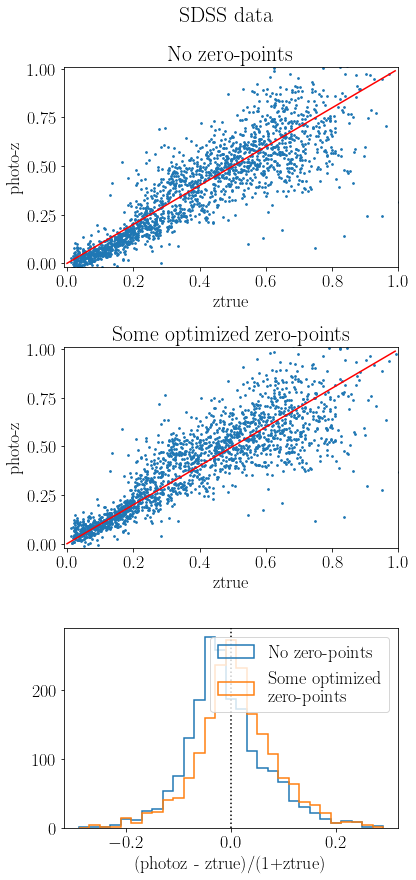

In [21]:
xdata = X_test[sel].copy()

zb_0 = prediction_zp(xdata, 0.*xchain[P.argmin()])
zb_zp = prediction_zp(xdata, xchain[P.argmin()])


fig,ax = plt.subplots(3,1, figsize=(6,14), sharex=False, sharey=False)
ax[0].scatter(y_test[sel], zb_0, s=3)
ax[0].plot([0,0.99],[0,0.99], color='r')
ax[0].set_xlim(-0.01,0.99+0.01)
ax[0].set_ylim(-0.02,0.99+0.02)
ax[0].set_xlabel('ztrue')
ax[0].set_ylabel('photo-z')
ax[0].set_title('No zero-points')

ax[1].scatter(y_test[sel], zb_zp, s=3)
ax[1].plot([0,0.99],[0,0.99], color='r')
ax[1].set_xlim(-0.01,0.99+0.01)
ax[1].set_ylim(-0.02,0.99+0.02)
ax[1].set_xlabel('ztrue')
ax[1].set_ylabel('photo-z')
ax[1].set_title('Some optimized zero-points')

dz_bins = 0.02
bins = np.arange(-0.3+dz_bins/2., 0.3, dz_bins)
ax[2].hist((zb_0-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='No zero-points')
ax[2].hist((zb_zp-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='Some optimized \nzero-points')
ax[2].axvline(0,ls=':',color='k')
ax[2].set_xlabel('(photoz - ztrue)/(1+ztrue)')
ax[2].legend()

fig.suptitle('SDSS data', y=0.94)
fig.subplots_adjust(hspace=0.4)
#plt.savefig('zeropoint_sdss_test1.png',bbox_inches='tight',dpi=300)
plt.show()

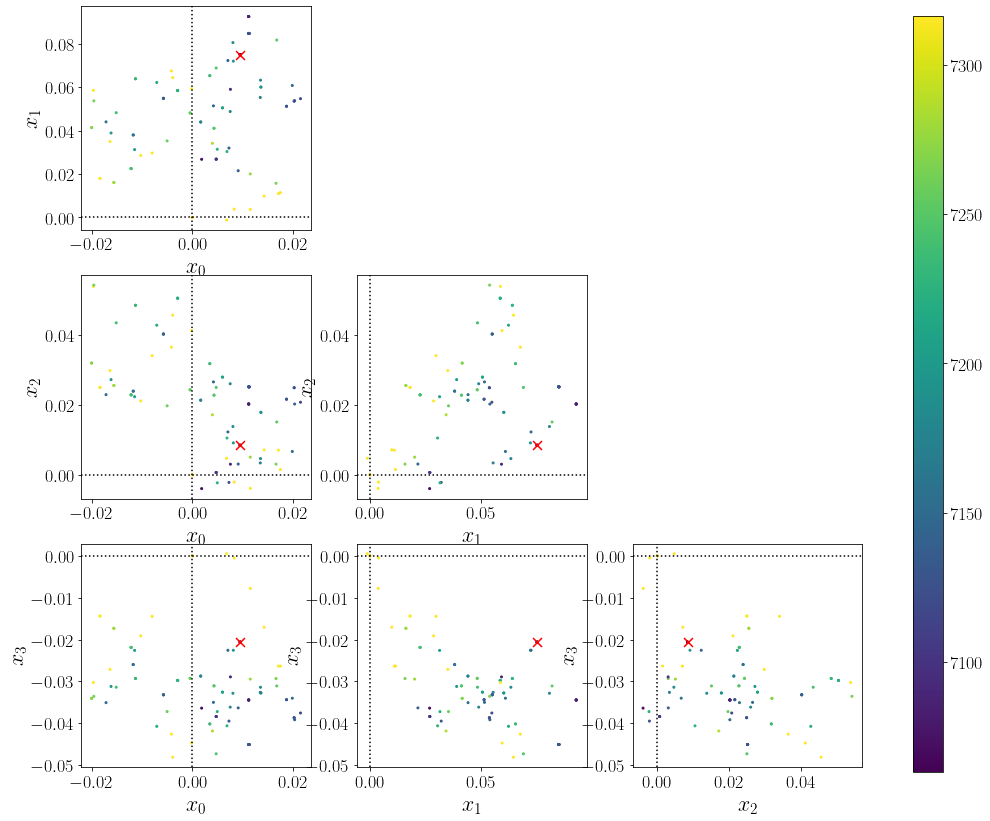

In [22]:
fig, ax = plt.subplots(3,3, figsize=(14,14))

for i in range(3):
    for j in range(3):
        if i<j:
            ax[i,j].axis('off')
            continue
            
        im = ax[i,j].scatter(xchain[:,j],xchain[:,i+1], s=4,c=P, vmin=P.min(), vmax=np.mean([P.min(),P.max()]))
        argmin = P.argmin()
        ax[i,j].scatter(xchain[argmin,j],xchain[argmin,i+1], s=80, c='r', marker='x')
        ax[i,j].set_xlabel(f'$x_{j}$', fontsize=22)
        ax[i,j].set_ylabel(f'$x_{i+1}$', fontsize=22)
        ax[i,j].axvline(0, ls=':', color='k')
        ax[i,j].axhline(0, ls=':', color='k')
        
        #assert false
        
#fig.colorbar(im,ax=ax[i,j])
cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax)
#fig.tight_layout()
plt.show()